# Readme
Reads the raw AIN1 ADC value on the Beaglebone Green<br>
Samples at approximately 1kHz (some overhead due to the OS, Python, no RTOS, etc.)<br>
Saves a JSON file of the data in samples/<br>
And plots a graph for visual verification of results (i.e. not too noisy, or missed movement)

## Beaglebone dependencies
Python 3.7.3 or higher<br>
`python3 -m pip install numpy==1.20 matplotlib jupyterlab`

## How to guide
1. Make sure the EMG sensor is properly connected, then connect the Beaglebone to the PC, wait for it to boot up (~1min)
2. Open a terminal and SSH into the beaglebone with: `ssh -L 8888:localhost:8888 debian@192.168.7.2`
3. Password is: **temppwd**
4. Start the jupyter server on the beaglebone with the command: `jupyter lab`
5. Copy the URL (localhost ... or, 127.0.0.1 ...) and paste it in a browser to open the jupyter environment, for example:<br>
    `http://localhost:8888/lab?token=389adbadce2bae7df571cf9f9d8c0ec12db68db033b7a1ab`
6. Run the Imports cell (mark it and hit `shift + enter`)

7. Open Cloud9 (http://192.168.7.2/) or SSH (`ssh debian@192.168.7.2`) to the beaglebone and check what files are in ~/samples/<br>
    I.e., currently the files are saved as "Number" + "Finger" + "movement" + "json", for example: "1ThumbFlexion.json"<br>
    **Dont overwrite data or new samples needs to be collected!**

8. Start sampling! For example: 10 x Thumb Flexion, 10 X Thumb Extension ... etc for all fingers where:<br>
    You need to **manually change `sample`** (and after 10 x the `movement` and `label`) in between collecting the data :(<br>
    Check graph that readings are OK! Might need to change electrode position, disconnect power from PC, etc.<br>
    <img src="sensorPlace2.jpg" width="600" height="400"><br>
    <img src="sensorPlace3.jpg" width="600" height="400"><br>
    ~3.5 cm from center to center of electrodes

9. After sampling is done, compress and archive the samples directory with the command, from the ~ directory: `tar -zcvf jsonData.tar.gz samples`

10. Copy the .tar.gz JSON data from the beaglebone to the PC, for example, in my terminal:<br>
    `scp debian@192.168.7.2:/home/debian/jsonData.tar.gz C:\Users\Seb\Desktop`

11. Open archive and unpack it on the PC --> We now have training data!

# Imports 

In [1]:
# Data collection
import time
from datetime import datetime
import json
import numpy as np
import matplotlib.pyplot as plt

# Sampling from ADC

## setting up data collection operating procedure:
1) run cell no.1 with the the name of the finger, movements, sample counter is zer at default.
2) run cell no.2 to collect data sample durations in ms initiated at 1000ms.
3) once the data is collected and analyzed for the movement, run cell no.3 to save it in JSON format.
4) repeat step 2 until enough data were collected for the movement.
5) change the name of the finger and the movement in step one and repeat for all the fingers.

In [274]:
########## CHANGE DEPENDING ON: FINGER, MOVEMENT, AMOUNT, SAMPLE NO ##########
#### cell no.1 #####
label = "Idle" # "Thumb" or "Index" or "Middle" or "Ring" or "Pinky"
movement = "Resting" # "Extension" or "Flexion"
sample = 30 #Increment manually, i.e., set to 1 first, then 2, 3 ...


Sampled 1000 samples in 1.000535249710083 s
Sample rate: 999


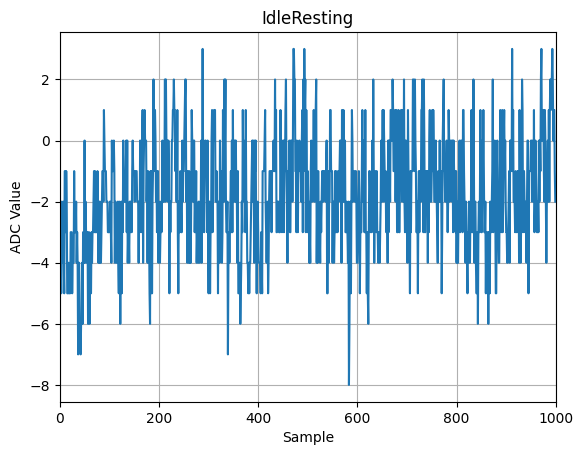

In [293]:
####### cell no.2 ########
np.set_printoptions(suppress=True) # No scientific notation

# Raw analog input pin to read from file
pin = 1
file = "/sys/bus/iio/devices/iio:device0/in_voltage{}_raw".format(pin)
fd = open(file, "r")

########## Sample duration  ################################################ 

sampleCount = 1000 # Amount of samples needed

############################################################################# 

sampleStart = sampleCount # For printouts
period = 0.001 # Sample period
data = [] # List of samples
t = time.time() # For controlling sample rate
startLoopTime = time.time() # For verification of sample rate accuracy

while True:
    t += period
    fd.seek(0) # Reset file pinter to begining of file
    value = float(fd.read().strip()) - 3412.0 # Read sensor value as float, CAN test with offset * 1.8/4096.0
    data.append(value) # Append sensor value to list
    time.sleep(max(0,t-time.time())) # Adjust sleep to get better time precision
    sampleCount -= 1
    if (sampleCount == 0): break # Change value to sample more
t2 = time.time()
fd.close()

#Some information how it went
print("\nSampled " + str(sampleStart) + " samples in " + str(t2 - startLoopTime) + " s")
print("Sample rate: " + str(1000 / (t2 - startLoopTime) ).split('.')[0])
data = np.array(data)
# Ψ[x(n)] = x²(n) - x(n+1)x(n-1)
# v = lambda x_t : np.abs(x_t[1:-1] * x_t[1:-1] - x_t[2:] * x_t[:-2])
#Plotting the data
plt.plot(data)
plt.xlabel('Sample')
plt.ylabel('ADC Value')
plt.title(label + movement)
plt.xlim(0, 1000)
# plt.ylim(-250, 150) #SHOULD be enough to contain min/max ADC values from our experiments, COULD be adjusted. Can test with (-2, 2) if using *1.8/4096.0 offset
plt.grid(True)

In [294]:
### cell no.3 ########## 
## save above data in a Json file
#Saving the data as a JSON fil
sample +=1 
jsonFileName = str(sample) + label + movement
jsonStructure = {'label': label, 'data': list(data)}
with open("samples/" + jsonFileName + ".json", 'w+') as f:
    json.dump(jsonStructure, f, indent = 4)
print(sample)

40


# Features and PCA
Work in progress

In [ ]:
# Prediction
import pandas as pd
from math import floor
from scipy.stats import skew, kurtosis
import sklearn
from numpy.lib.stride_tricks import as_strided, sliding_window_view
import pickle

with open('pca.pkl','rb') as pkl:
    pca = pickle.load(pkl)

# This implementation is derived from numpy.lib.stride_tricks.sliding_window_view (1.20.0)
# https://numpy.org/doc/stable/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html
def frame(x: np.ndarray, *, frame_length, hop_length, axis = -1, writeable = False, subok = False):
    x = np.array(x, copy=False, subok=subok)

    if x.shape[axis] < frame_length:
        raise Exception(f"Input is too short (n={x.shape[axis]:d}) for frame_length={frame_length:d}")

    if hop_length < 1:
        raise Exception(f"Invalid hop_length: {hop_length:d}")

    # put our new within-frame axis at the end for now
    out_strides = x.strides + tuple([x.strides[axis]])

    # Reduce the shape on the framing axis
    x_shape_trimmed = list(x.shape)
    x_shape_trimmed[axis] -= frame_length - 1

    out_shape = tuple(x_shape_trimmed) + tuple([frame_length])
    xw = as_strided(x, strides=out_strides, shape=out_shape, subok=subok, writeable=writeable)

    if axis < 0:
        target_axis = axis - 1
    else:
        target_axis = axis + 1

    xw = np.moveaxis(xw, -1, target_axis)

    # Downsample along the target axis
    slices = [slice(None)] * xw.ndim
    slices[axis] = slice(0, None, hop_length)
    return xw[tuple(slices)]

##### Features
def root_mean_squared(y,frame_length,hop_length):
    return np.sqrt(np.mean(frame(y, frame_length = frame_length , hop_length = hop_length) ** 2, axis = 0))

def iemg(y, frame_length, hop_length):
    return np.abs(frame(y, frame_length = frame_length , hop_length = hop_length)).sum(axis = 0)

def mean_absolute_value(y, frame_length, hop_length):
    return np.mean(np.abs(frame(y, frame_length = frame_length , hop_length = hop_length)), axis = 0)

def variance(y, frame_length, hop_length):
    return frame(y, frame_length = frame_length , hop_length = hop_length).var(axis = 0)

def wave_form_length(y, frame_length, hop_length):
    frames = frame(y, frame_length = frame_length , hop_length = hop_length)
    diff = np.diff(frames, axis = 0)
    absolute = np.abs(diff)
    sum = np.sum(absolute, axis = 0)
    return sum

def mean(y, frame_length, hop_length):
    return frame(y, frame_length = frame_length , hop_length = hop_length).mean(axis = 0)

def median(y, frame_length, hop_length):
    frames = frame(y, frame_length = frame_length , hop_length = hop_length)
    return np.median(frames, axis = 0)

def skewness(y, frame_length, hop_length):
    frames = frame(y, frame_length = frame_length , hop_length = hop_length)
    return skew(frames, axis = 0)

def kurt(y, frame_length, hop_length):
    frames = frame(y, frame_length = frame_length , hop_length = hop_length)
    return kurtosis(frames, axis = 0)

def zero_crossing_rate(y, frame_length, hop_length):
    frames = frame(y, frame_length = frame_length , hop_length = hop_length)
    signs = np.sign(frames)
    difference = np.diff(signs, axis = 0)
    absolute = np.abs(difference)
    means= np.mean(absolute, axis = 0)
    return means / 2 ## needs fixing <------------------------------ ???


### THESE 4 ARE NOT USED Why or why not :D ###
def variance(y, frame_length, hop_length):
    return frame(y, frame_length = frame_length , hop_length = hop_length).var(axis = 0)

def standard_deviation(y, frame_length, hop_length):
    frames = frame(y, frame_length = frame_length , hop_length = hop_length)
    return np.std(frames, axis = 0)

def minimum(y, frame_length, hop_length):
    frames = frame(y, frame_length = frame_length , hop_length = hop_length)
    return np.min(frames, axis = 0)

def maximum(y, frame_length, hop_length):
    frames = frame(y, frame_length = frame_length , hop_length = hop_length)
    return np.max(frames, axis = 0)


def feature_extraction(data, features_no, overlapping_percentage = 0.25, functions = []):

    features = []
    
    for func in functions:
        frames = floor((len(data) / features_no) + floor(overlapping_percentage * len(data)))
        hops = int((1 - overlapping_percentage) * floor((len(data)) / features_no))
        features.extend(func(y = data, frame_length = frames, hop_length = hops))
    
    return np.array(features)

features = [root_mean_squared, iemg, mean_absolute_value, variance, wave_form_length, mean, median, skewness, kurt, zero_crossing_rate]
#features = [mean_absolute_value]

#feature_vector = feature_extraction(data, features_no = 11, overlapping_percentage = 0.25, functions = features)#.reshape(1, -1)

things = sliding_window_view(np.array(data), window_shape = 250)

print(things[0])

stuff = sliding_window_view(np.array(data), window_shape = 250)[::2, :] #only jumps / hops / strides by 1

print(stuff[0])

print("Feature vector is: ")
#print(feature_vector)
print("Feature vector lenght is: " + str(len(feature_vector)))

feature_vector = feature_vector.reshape(1, -1)
components = pca.transform(feature_vector)
print("After PCA: ")
print(components)

In [295]:
import os
import zipfile

zf = zipfile.ZipFile("samples.zip", "w")
for dirname, subdirs, files in os.walk("./samples/"):
    zf.write(dirname)
    for filename in files:
        zf.write(os.path.join(dirname, filename))
zf.close()

In [291]:
! pwd

/home/debian/sampler
